In [15]:
import csv
import datetime
import collections
import statistics 

import os
import psycopg2
import pandas as pd
import re
import shutil
import time
from psycopg2.extras import DictCursor
from contextlib import contextmanager
import matplotlib.pyplot as plt

In [13]:
 # https://www.psycopg.org/docs/extras.html?highlight=dictcursor#psycopg2.extras.DictCursor
 con = psycopg2.connect(database="", user="", password="")
 print("connected with Database successfully")

connected with Database successfully


In [14]:
@contextmanager
def timed_cursor():
    start_time = time.time()
    yield con.cursor(cursor_factory=DictCursor)
    print("--- %s seconds ---" % (time.time() - start_time))

In [15]:
# # Create tables
# def create_table(sql_file):
#     with timed_cursor() as cur:
#             query = open(sql_file, 'r') 
#             cur.execute(query.read())
#             con.commit() # Make the changes to the database persistent

In [16]:
# # Execute Script(process/install/) Instead
# create_table("../sql/create_table_cve_revs.sql") # Create table cve_revs
# create_table("../sql/create_table_cve_revs_js.sql") # Create table cve_revs_js
# create_table("../sql/create_table_cve_revs_py.sql") # Create table cve_revs_py

In [17]:
def get_cve(row):
    rv = list()
    for regex in regexes:
        rv.extend(list(set(regex.findall(row['msg']))))
    if not rv and regex_sql_inj.search(row['msg']):
        rv.append("sql_injection")
    return rv

In [18]:
def copy_cwe(row):
    if not isinstance(row['cve_data'], str):
        return row['cwe_group']
    if 'CWE' in row['cve_data']:
        return row['cve_data']
    return row['cwe_group']

In [19]:
def create_statistics(df, lang):
    cwe_counts = df['cwe_group'].value_counts()
    cwe_counts.to_csv(os.path.join(res_dir, f'count_cwe_groups_{lang}.csv'), header=False)

    severity_counts = df['severity'].value_counts()
    severity_counts.to_csv(os.path.join(res_dir, f'count_severity_{lang}.csv'), header=False)

    avg_impacts = df['impact_score'].describe()
    avg_impacts.to_csv(os.path.join(res_dir, f'stat_impact_score_{lang}.csv'), header=False)

    # Bug Fix -> "Array must be all same time zone"
    df['commit_date'] = pd.to_datetime(df['commit_date'], utc=True)

    stat_yearly = df[['commit_date']]
    stat_yearly = stat_yearly.groupby(stat_yearly.commit_date.dt.year).count()
    stat_yearly.to_csv(os.path.join(res_dir, f'fixes_per_year_{lang}.csv'), header=False)

    cwe_group_year = df[['commit_date', "cwe_group"]]
    cwe_group_year = cwe_group_year.groupby([cwe_group_year.commit_date.dt.year, 'cwe_group']).count()
    cwe_group_year.to_csv(os.path.join(res_dir, f'count_cwe_groups_by_year_{lang}.csv'), header=False)

In [20]:
def run_on(lang):
    df = None
    with timed_cursor() as cur:
        query = f"SELECT * FROM cve_revs_{lang}"
        df = pd.read_sql_query(query, con=con)
    if df is None:
        print("Query failed")
        return

    # Extract CVE number
    df['cve_data'] = df.apply(lambda row: get_cve(row), axis=1)

    # Explode revisions with multiple CVE
    df = df.explode("cve_data")

    # CVEs should be all uppered
    df['cve_data'] = df['cve_data'].str.upper()

    # Clean unnecessary fields
    del df['msg']
    # Bug Fix -> There is no column named cve
    # del df['cve']

    # Drop false rows
    df = df[df.cve_data.notnull()]

    # JOIN the cve_list to the data
    df = df.merge(cve_list, on="cve_data", how="left")
    # Bug Fix -> Add published_date,severity,impact_score
    df = pd.merge(df,cvss_list[['cve_data','published_date','severity','impact_score']],on='cve_data', how='left')
    # Copy CWE if CWE was used in commit message
    df['cwe_group'] = df.apply(lambda row: copy_cwe(row), axis=1)

    # Save csv
    df.to_csv(os.path.join(res_dir, rf'result_{lang}.csv'))

    create_statistics(df, lang)

In [21]:
def select_random_rows(table, limit):
    sql = f"select * from {table} order by random() limit {limit};"
    with timed_cursor() as cur:
        df = pd.read_sql_query(sql, con=con)
        with open(os.path.join(res_dir, f"sample_from_{table}.txt"), 'w') as f:
            for rec_index, rec in df.iterrows():
                f.write(f'------- commit message {rec_index} starts -------\n')
                f.write(rec['msg'])
                f.write('\n------- commit message ends -------\n')

In [22]:
res_dir = '../../data/results'

regex_cve = re.compile(r"(CVE-\d{4}-\d{4,})", re.IGNORECASE)
regex_cwe = re.compile(r"(CWE-[\d]{1,4})", re.IGNORECASE)
regex_nvd = re.compile(r"(NVD .+)", re.IGNORECASE)
regex_sql_inj = re.compile(r"sql ?injection", re.IGNORECASE)

regexes = [regex_cve, regex_cwe, regex_nvd]

cve_list = pd.read_csv(os.path.join("../../data/cve_parsed", "cve_related_problems.csv"), sep="\t")
# Bug Fix -> Rename CVE to cve_data
cve_list.rename(columns={"CVE": "cve_data", "Problem": "cwe_group"}, inplace=True)

# CVSS Scores
# Bug Fix -> Add published_date,severity,impact_score -> This Data wasn't available previously 
cvss_list = pd.read_csv(os.path.join("../../data/cve_parsed", "cve_cvss_scores.csv"), sep="\t")
# Bug Fix -> Rename Columns - CVE, "Published Date", "Impact Score"
cvss_list.rename(columns={"CVE": "cve_data", "Published Date": "published_date", "Impact Score": "impact_score"}, inplace=True)

if os.path.exists(res_dir):
    shutil.rmtree(res_dir)
os.makedirs(res_dir)
run_on("js")
run_on("py")

# select_random_rows("cve_revs_py", 348)
# select_random_rows("cve_revs_js", 352)

--- 0.0020012855529785156 seconds ---
--- 0.007999658584594727 seconds ---


In [419]:
# stat.py
# JS_CSV = os.path.join("../../data/results", "result_js.csv")
# PY_CSV = os.path.join("../../data/results", "result_py.csv")
# js_reader = csv.reader(open(JS_CSV, 'r'), delimiter=',', quotechar='"')
# py_reader = csv.reader(open(PY_CSV, 'r'), delimiter=',', quotechar='"')

# next(js_reader)
# next(py_reader)
# for r in js_reader, py_reader:
#     print(r)
#     y_dict = collections.defaultdict(list)
#     for row in r:
#         if row[5]:
#             cwe = row[4]
#             commit_date = datetime.datetime.strptime(row[2].split('+')[0], '%Y-%m-%d %H:%M:%S')
#             publish_date = datetime.datetime.strptime(row[5], '%Y-%m-%dT%H:%MZ')
#             delta = (commit_date-publish_date).days if (commit_date-publish_date).days>0 else 0
#             y_dict[commit_date.year].append(delta)
#     for y in y_dict.keys():
#         print(f"{y},{statistics.mean(y_dict[y])}")

2014,0
2015,0
2016,1.4074074074074074
2017,71.75555555555556
2018,32.111111111111114
2008,220.2
2010,204.85714285714286
2011,0
2012,39.44444444444444
2013,0.2127659574468085
2014,36.8
2015,44.8
2016,9.6
2017,172.11363636363637
2018,76.18987341772151


,js_delta,py_delta
commit_date,,
2008,NaN,220.000000
2010,NaN,204.857143
2011,NaN,0.000000
2012,NaN,39.444444
2013,NaN,0.212766
2014,0.000000,36.800000
2015,0.000000,44.800000
2016,1.407407,9.600000
2017,71.733333,172.113636


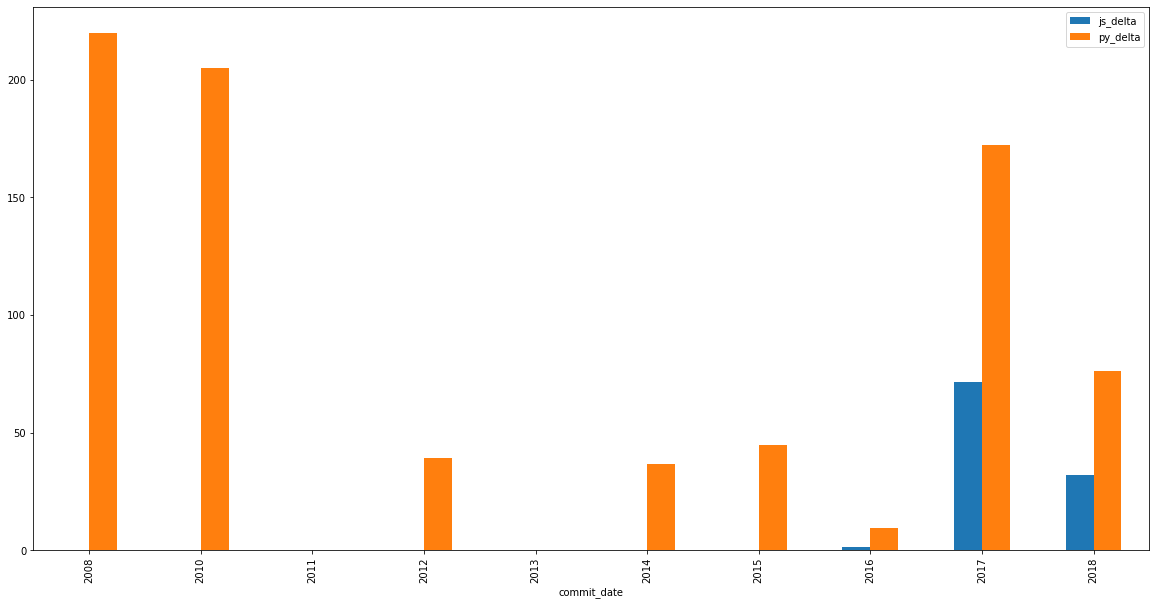

In [520]:
# stat
js_result_csv = pd.read_csv( os.path.join("../../data/results", "result_js.csv"),index_col=0).dropna(subset=['published_date'])
py_result_csv = pd.read_csv( os.path.join("../../data/results", "result_py.csv"),index_col=0).dropna(subset=['published_date'])

js_result_csv[['published_date','commit_date']] = js_result_csv[['published_date','commit_date']].apply(pd.to_datetime,utc=True)
js_result_csv['js_delta'] = ((js_result_csv['commit_date'] - js_result_csv['published_date']).dt.days).apply(lambda val: val if val>0 else 0)
js_stat_1 = js_result_csv.query('js_delta >= 0').drop(columns=['impact_score']).groupby(js_result_csv['commit_date'].dt.year).agg('mean')

py_result_csv[['published_date','commit_date']] = py_result_csv[['published_date','commit_date']].apply(pd.to_datetime,utc=True)
py_result_csv['py_delta'] = ((py_result_csv['commit_date'] - py_result_csv['published_date']).dt.days).apply(lambda val: val if val>0 else 0)
py_stat_1 = py_result_csv.query('py_delta >= 0').drop(columns=['impact_score']).groupby(py_result_csv['commit_date'].dt.year).agg('mean')

stat_1 = pd.concat([js_stat_1, py_stat_1], axis=1)
stat_1.plot(kind='bar', figsize=(20,10))
stat_1

In [497]:
# Stat2.py - Original Code
# Note: Columns 'NVD-CWE-noinfo' & 'NVD-CWE-Other' are not Excluded
#       So it will affect result of JS CWEs, Py CWEs & Common
# js_csv = os.path.join("../../data/results", "count_cwe_groups_js.csv")
# py_csv = os.path.join("../../data/results", "count_cwe_groups_py.csv")

# js_r = csv.reader(open(js_csv, 'r'), delimiter=',', quotechar='"')
# py_r = csv.reader(open(py_csv, 'r'), delimiter=',', quotechar='"')

# js_cwe = dict()
# py_cwe = dict()

# next(js_r)
# next(py_r)

# for row in js_r:
#     js_cwe[row[0]] = row[1]
    
# for row in py_r:
#     py_cwe[row[0]] = row[1]
    
# cwes = set(js_cwe.keys())
# cwes.update(py_cwe.keys())

# print(f"JS CWEs: {len(js_cwe.keys())}, Py CWEs: {len(py_cwe.keys())}, Common: {len(cwes)}")

# for cwe in cwes:
#     js_count = js_cwe[cwe] if cwe in js_cwe.keys() else 0
#     py_count = py_cwe[cwe] if cwe in py_cwe.keys() else 0
#     if int(js_count) > 10 or int(py_count) > 10:
#         print(f"{cwe},{js_count},{py_count}")

JS CWEs: 25, Py CWEs: 31, Common: 43
NVD-CWE-noinfo,1,34
CWE-119,3,17
NVD-CWE-Other,0,12
CWE-601,20,35
CWE-79,0,14
CWE-310,0,14
CWE-399,1,31
CWE-125,13,1
CWE-185,9,12
CWE-200,20,18
CWE-189,0,18
CWE-787,13,0


JavaScript CVEs: 25
Python CVEs: 30
Common CVEs: 41


,js,py
CWE-119,3.0,17.0
CWE-125,13.0,1.0
CWE-185,9.0,12.0
CWE-189,NaN,18.0
CWE-20,6.0,69.0
CWE-200,20.0,18.0
CWE-310,NaN,14.0
CWE-399,1.0,31.0
CWE-601,20.0,35.0
CWE-787,13.0,NaN


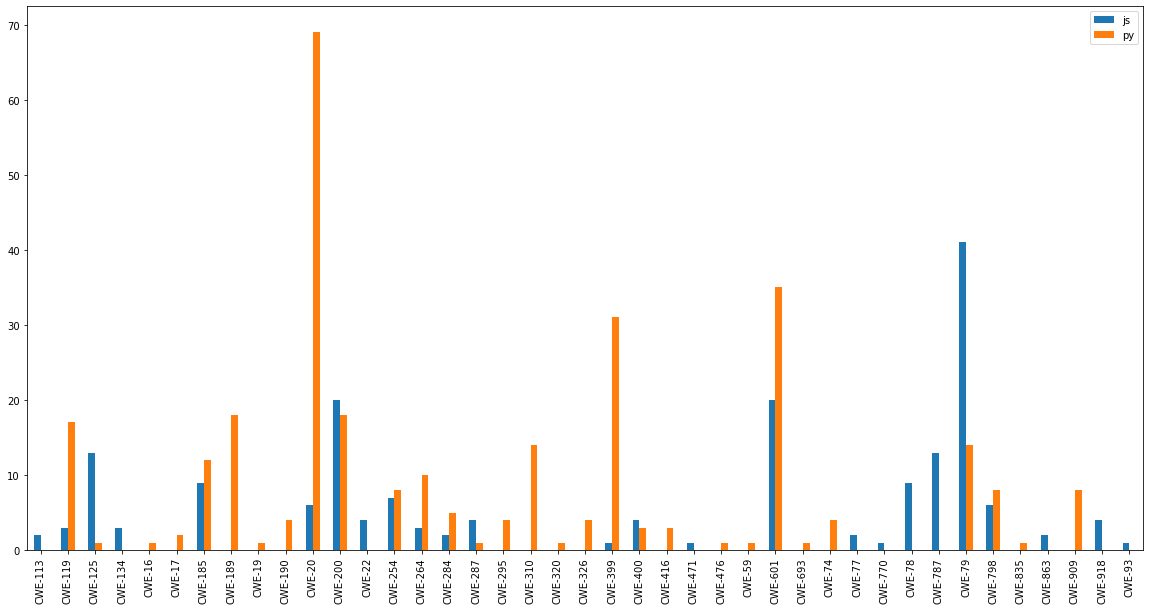

In [521]:
# Stat2
js_count_cwe_groups_csv = pd.read_csv( os.path.join("../../data/results", "count_cwe_groups_js.csv"), header=None, names=['CWE','js'], index_col='CWE')
py_count_cwe_groups_csv = pd.read_csv( os.path.join("../../data/results", "count_cwe_groups_py.csv"), header=None, names=['CWE','py'], index_col='CWE')

# Excluding Columns 'NVD-CWE-noinfo' & 'NVD-CWE-Other'
js_count_cwe_groups_csv = js_count_cwe_groups_csv.filter(regex=r'CWE-.[\d]+', axis=0)
py_count_cwe_groups_csv = py_count_cwe_groups_csv.filter(regex=r'CWE-.[\d]+', axis=0)

# ax = js_csv.plot(kind='bar',figsize=(20,10))
# py_csv.plot(ax=ax, kind='bar')

stat_2 = pd.concat([js_count_cwe_groups_csv, py_count_cwe_groups_csv], axis=1)
js_count = len(stat_2['js'].dropna())
py_count = len(stat_2['py'].dropna())
print("JavaScript CVEs: "+ str(js_count))
print("Python CVEs: "+ str(py_count))
print("Common CVEs: "+ str(len(stat_2)))
stat_2.plot(kind='bar', figsize=(20,10))
stat_2 = stat_2.query('js > 10 or py >10')
# stat_2.plot(kind='bar', figsize=(20,10))
stat_2

In [505]:
# stat3.py
# CWE = [
#         "CWE-79",
#         "CWE-399",
#         "CWE-200",
#         "CWE-20",
#         "CWE-264",
#         "CWE-400",
#         "CWE-119",
#         "CWE-22"
#       ]
# JS_CSV = os.path.join("../../data/results", "result_js.csv")
# PY_CSV = os.path.join("../../data/results", "result_py.csv")
# js_reader = csv.reader(open(JS_CSV, 'r'), delimiter=',', quotechar='"')
# py_reader = csv.reader(open(PY_CSV, 'r'), delimiter=',', quotechar='"')

# # next(js_reader)
# # next(py_reader)
# for r in js_reader, py_reader:
#     print(r)
#     y_dict = collections.defaultdict(list)
#     for row in r:
#         if row[5]:
#             cwe = row[4]
#             if cwe not in CWE:
#                 continue
#             commit_date = datetime.datetime.strptime(row[2].split('+')[0], '%Y-%m-%d %H:%M:%S')
#             publish_date = datetime.datetime.strptime(row[5], '%Y-%m-%dT%H:%MZ')
#             delta = (commit_date-publish_date).days if (commit_date-publish_date).days>0 else 0
#             y_dict[cwe].append(delta)
#     for y in y_dict.keys():
#         print(f"{y},{statistics.mean(y_dict[y])}")

CWE-79,13.75609756097561
CWE-200,0
CWE-264,0
CWE-119,232.33333333333334
CWE-20,0
CWE-399,396
CWE-400,0.5
CWE-22,0
CWE-119,107.17647058823529
CWE-264,1.8
CWE-20,33.6231884057971
CWE-399,0.12903225806451613
CWE-79,0.2857142857142857
CWE-200,43.55555555555556
CWE-400,1


,js_delta,py_delta
CWE-119,232.333333,107.176471
CWE-20,0.000000,33.623188
CWE-200,0.000000,43.555556
CWE-22,0.000000,NaN
CWE-264,0.000000,1.800000
CWE-399,396.000000,0.129032
CWE-400,0.500000,1.000000
CWE-79,13.731707,0.285714


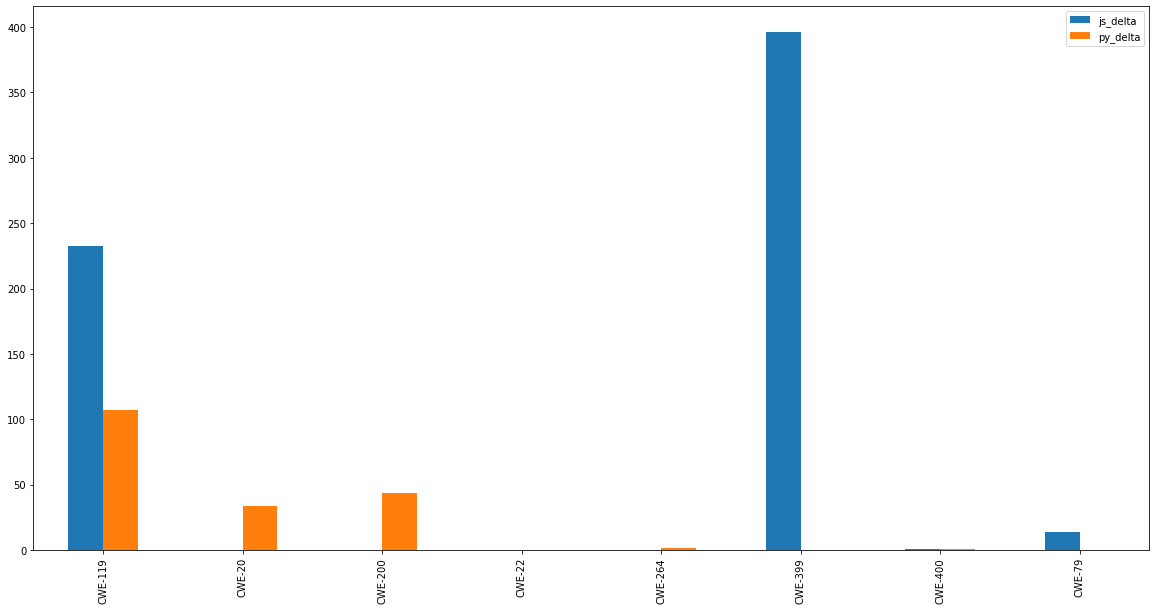

In [524]:
# stat3.py
CWE = [
        "CWE-79",
        "CWE-399",
        "CWE-200",
        "CWE-20",
        "CWE-264",
        "CWE-400",
        "CWE-119",
        "CWE-22"
      ]

js_stat_3 = js_result_csv.query('js_delta >= 0 and cwe_group in @CWE').drop(columns=['impact_score']).groupby(js_result_csv['cwe_group']).agg('mean')

py_stat_3 = py_result_csv.query('py_delta >= 0 and cwe_group in @CWE').drop(columns=['impact_score']).groupby(py_result_csv['cwe_group']).agg('mean')

stat_3 = pd.concat([js_stat_3, py_stat_3], axis=1)
stat_3.plot(kind='bar', figsize=(20,10))
stat_3

In [855]:
# stat4.py
# CWE = [
#         "CWE-79",
#         "CWE-399",
#         "CWE-200",
#         "CWE-20",
#         "CWE-264",
#         "CWE-400",
#         "CWE-119",
#         "CWE-22"
#       ]
# JS_CSV = os.path.join("../../data/results", "count_cwe_groups_by_year_js.csv")
# PY_CSV = os.path.join("../../data/results", "count_cwe_groups_by_year_py.csv")
# js_reader = csv.reader(open(JS_CSV, 'r'), delimiter=',', quotechar='"')
# py_reader = csv.reader(open(PY_CSV, 'r'), delimiter=',', quotechar='"')

# years = [i for i in range(2006, 2020)]

# # Bug Fix -> There is no need to skip lines as there are no headers
# # next(js_reader)
# # next(py_reader)
# y_dict = {cwe: [0]*len(years) for cwe in CWE}
# print(y_dict)
# for r in js_reader, py_reader:
#     print(r)
#     for row in r:
#         cwe = row[1]
#         year = int(row[0])
#         count = int(row[2])
#         if cwe not in CWE:
#             continue
#         # print(cwe)
#         # print(year)
#         # print(years.index(year))
#         y_dict[cwe][years.index(year)] = count
#     for y in y_dict.keys():
#         str_list = map(lambda x: str(x), y_dict[y])
#         print(f"{y},{','.join(str_list)}")


js_count  py_count
CWE     year                    
CWE-119 2008       NaN       2.0
        2010       NaN      10.0
        2015       NaN       3.0
        2017       3.0       2.0
CWE-20  2012       NaN      10.0
        2013       NaN      12.0
        2014       NaN       2.0
        2017       NaN      45.0
        2018       6.0       NaN
CWE-200 2015       2.0       2.0
        2016       2.0       8.0
        2017       NaN       1.0
        2018      16.0       7.0
CWE-22  2018       4.0       NaN
CWE-264 2011       NaN       1.0
        2013       NaN       4.0
        2014       NaN       1.0
        2016       3.0       4.0
CWE-399 2012       NaN      24.0
        2013       NaN       6.0
        2015       NaN       1.0
        2018       1.0       NaN
CWE-400 2017       NaN       3.0
        2018       4.0       NaN
CWE-79  2014      12.0       NaN
        2015       6.0       1.0
        2016       7.0      10.0
        2017       3.0       3.0
        2018      13.0       NaN

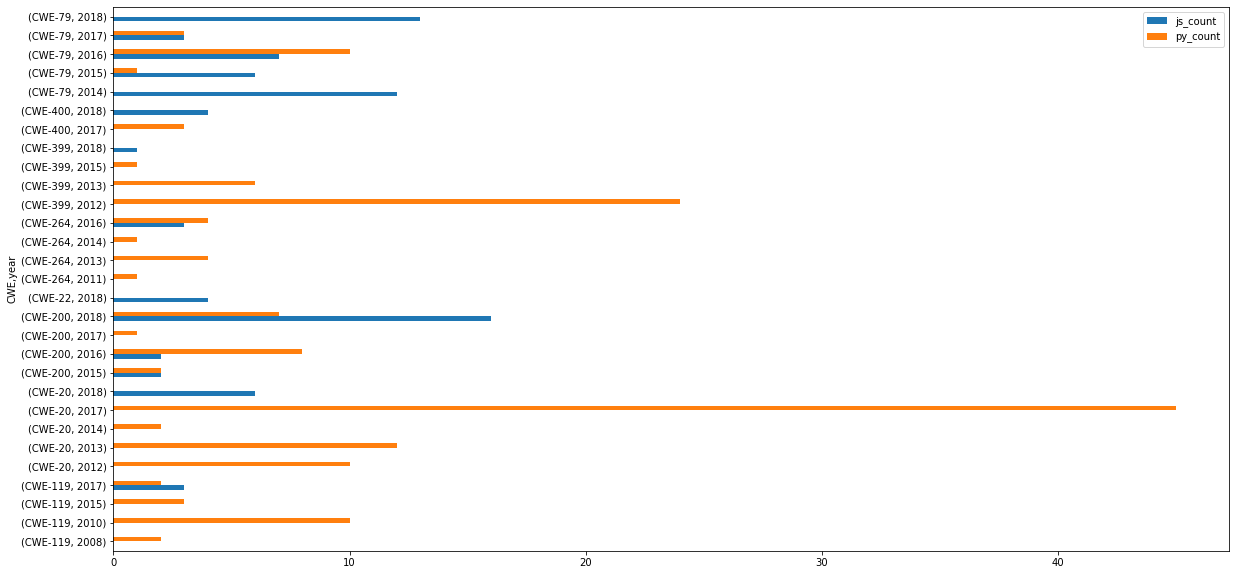

In [854]:
# stat4.py
CWE = [
        "CWE-79",
        "CWE-399",
        "CWE-200",
        "CWE-20",
        "CWE-264",
        "CWE-400",
        "CWE-119",
        "CWE-22"
      ]
js_cwe_groups_by_year_csv = pd.read_csv( os.path.join("../../data/results", "count_cwe_groups_by_year_js.csv"), header=None, names=['year','CWE','js_count'], index_col='year')
py_cwe_groups_by_year_csv = pd.read_csv( os.path.join("../../data/results", "count_cwe_groups_by_year_py.csv"), header=None, names=['year','CWE','py_count'], index_col='year')

js_stat_4 = js_cwe_groups_by_year_csv.query('CWE in @CWE').groupby(['CWE','year']).sum()
py_stat_4 = py_cwe_groups_by_year_csv.query('CWE in @CWE').groupby(['CWE','year']).sum()

stat_4 = pd.concat([js_stat_4, py_stat_4], axis=1)
stat_4.plot(kind='barh', figsize=(20,10))
stat_4

In [856]:
JS_CSV = os.path.join("../../data/results", "count_cwe_groups_by_year_js.csv")
PY_CSV = os.path.join("../../data/results", "count_cwe_groups_by_year_py.csv")
# js_reader = csv.reader(open(JS_CSV, 'r'), delimiter=',', quotechar='"')
# py_reader = csv.reader(open(PY_CSV, 'r'), delimiter=',', quotechar='"')

for f in [JS_CSV, PY_CSV]:
    r = csv.reader(open(f, 'r'), delimiter=',', quotechar='"')
    yearly = dict()
    print(r)
    for row in r:
        cwe = row[1]
        year = int(row[0])
        count = int(row[2])
        if year not in yearly:
            yearly[year] = count
        yearly[year] += count
        print(row)

    out = "yearly_commits_"+f[-6:]
    with open(os.path.join("../../data/results", out), "w", encoding="utf8") as fp:
        for y, c in yearly.items():
            fp.write(f"{y};{c}\n")

['2014', 'CWE-79', '12']
['2015', 'CWE-200', '2']
['2015', 'CWE-79', '6']
['2016', 'CWE-134', '1']
['2016', 'CWE-200', '2']
['2016', 'CWE-254', '4']
['2016', 'CWE-264', '3']
['2016', 'CWE-284', '2']
['2016', 'CWE-77', '2']
['2016', 'CWE-79', '7']
['2016', 'CWE-798', '6']
['2017', 'CWE-119', '3']
['2017', 'CWE-125', '13']
['2017', 'CWE-601', '12']
['2017', 'CWE-787', '13']
['2017', 'CWE-79', '3']
['2017', 'CWE-93', '1']
['2018', 'CWE-113', '2']
['2018', 'CWE-134', '2']
['2018', 'CWE-185', '9']
['2018', 'CWE-20', '6']
['2018', 'CWE-200', '16']
['2018', 'CWE-22', '4']
['2018', 'CWE-254', '3']
['2018', 'CWE-287', '4']
['2018', 'CWE-399', '1']
['2018', 'CWE-400', '4']
['2018', 'CWE-471', '1']
['2018', 'CWE-601', '8']
['2018', 'CWE-770', '1']
['2018', 'CWE-78', '9']
['2018', 'CWE-79', '13']
['2018', 'CWE-863', '2']
['2018', 'CWE-918', '4']
['2018', 'NVD-CWE-noinfo', '1']
['2008', 'CWE-119', '2']
['2008', 'CWE-189', '18']
['2010', 'CWE-119', '10']
['2010', 'NVD-CWE-Other', '8']
['2010', 'NVD-

js_count  py_count
CWE     year                    
CWE-113 2018       2.0       NaN
CWE-119 2008       NaN       2.0
        2010       NaN      10.0
        2015       NaN       3.0
        2017       3.0       2.0
...                ...       ...
CWE-835 2017       NaN       1.0
CWE-863 2018       2.0       NaN
CWE-909 2018       NaN       8.0
CWE-918 2018       4.0       NaN
CWE-93  2017       1.0       NaN

[71 rows x 2 columns]

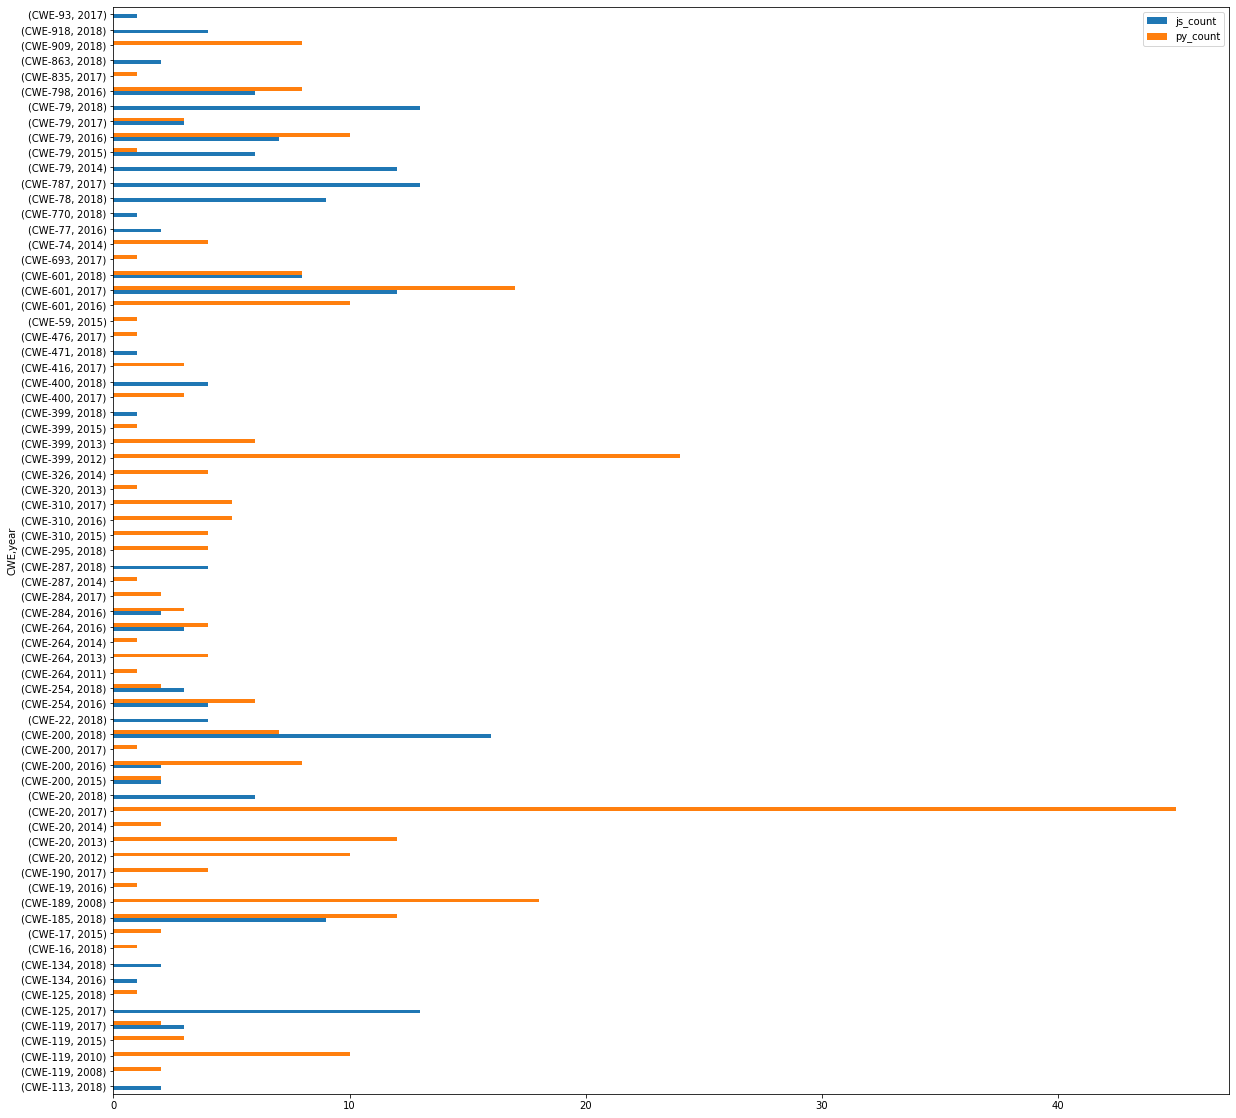

In [878]:
js_stat_5 = js_cwe_groups_by_year_csv.groupby(['CWE','year']).sum()
py_stat_5 = py_cwe_groups_by_year_csv.groupby(['CWE','year']).sum()

stat_5 = pd.concat([js_stat_5, py_stat_5], axis=1).filter(regex=r'CWE-.[\d]+', axis=0)
stat_5.plot(kind='barh', figsize=(20,20))
stat_5